In [1]:
# 全局设置
import sys
import datetime as dt

import numpy as np
import pandas as pd

import QuantStudio.api as QS
fd = QS.FactorDB.FactorTools

HDB = QS.FactorDB.HDF5DB(config_file="../../config/HDF5DBConfig.json").connect();

RDB = QS.RiskDB.HDF5FRDB(config_file="../../config/HDF5FRDBConfig.json").connect();

投资组合策略给出每一期要持有的证券, 以及证券对应的资金配置权重. 定义投资组合策略的信号格式为: Series(权重值, index=[ID]) 或者 None(表示无信号), 每个 ID 投资组合信号权重值的可能范围及其含义:
* `=0` 表示清空所有头寸;
* `>0` 表示做多, 数值为多头资金占比
* `<0` 表示做空, 数值为空头资金占比

Strategy.genSignal() 方法的返回值必须遵守以上约定. 用户实现的投资组合策略类应该继承自 Strategy.PortfolioStrategy.

# 自定义策略


以下是一个简单的投资组合策略示例, 策略的逻辑为选择反转因子(过去 20 个交易日的收益率)最小的 10 只股票构建等权组合, 纯多头策略.

==========历史回测==========
1. 初始化
耗时 : 9.03
2. 循环计算


100% (1035 of 1035) |####################| Elapsed Time: 0:10:00 Time:  0:10:00


耗时 : 607.92
3. 结果生成
耗时 : 0.55
总耗时 : 617.50


,绝对表现,基准表现,相对表现
起始时点,2015-01-30,2015-01-30,2015-01-30
结束时点,2019-04-30,2019-04-30,2019-04-30
时点数,1035,1035,1035
总收益率,100.88%,13.94%,67.73%
年化收益率,17.92%,3.12%,12.94%
年化波动率,31.49%,24.70%,26.05%
Sharpe比率,0.51,0.05,0.42
收益风险比,0.57,0.13,0.50
胜率,52.75%,53.24%,48.41%
最大回撤率,58.68%,46.70%,57.45%

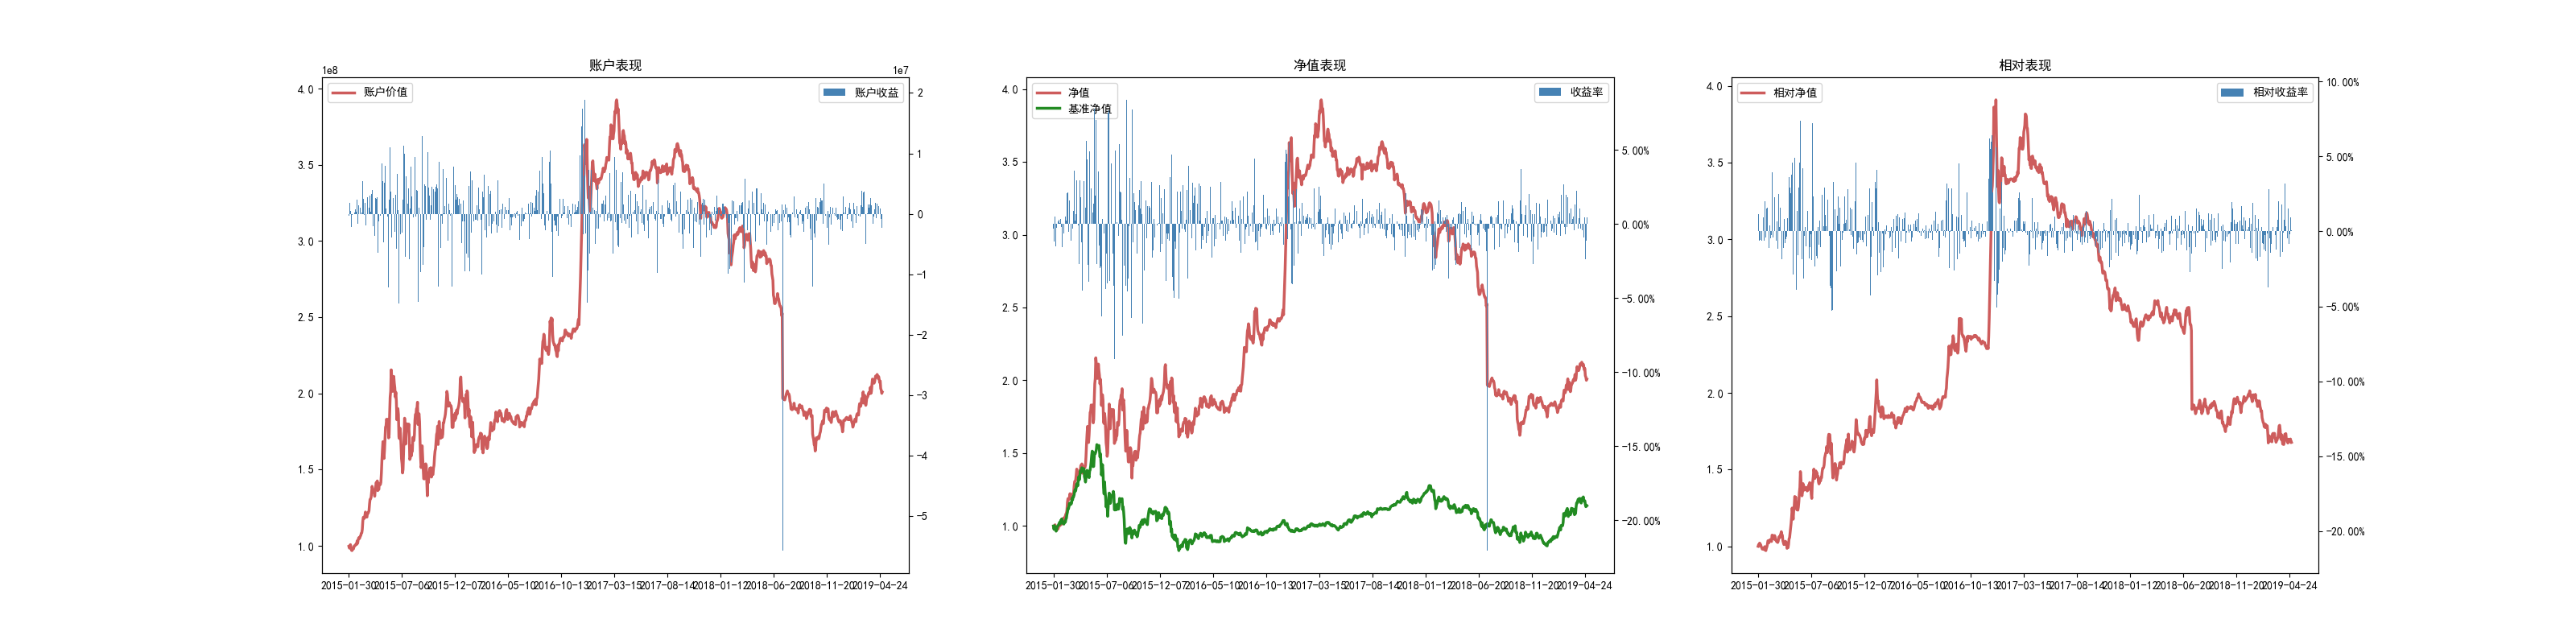

In [2]:
# 自定义选股策略
# 定义策略逻辑
class MyPortfolioStrategy(QS.BackTest.Strategy.PortfolioStrategy):
    def init(self):
        return 0
    def genSignal(self, idt, trading_record):
        FilterStr = "(@if_listed==1) & (@if_trading==1)"
        IDs = self.MainFactorTable.getFilteredID(idt=idt, id_filter_str=FilterStr)
        FactorData = self.MainFactorTable.readData(factor_names=["alpha"], ids=IDs, dts=[idt]).iloc[0, 0, :]
        FactorData = FactorData.sort_values(ascending=True)
        Signal = pd.Series(1.0/self.ModelArgs["TargetNum"], index=FactorData.index[:self.ModelArgs["TargetNum"]])
        return Signal

StartDT, EndDT = dt.datetime(2015, 1, 30), dt.datetime(2019, 4, 30)

# 获取基本信息
FT = HDB.getTable("stock_cn_day_bar_adj_backward_nafilled")
DTs = FT.getDateTime(ifactor_name="close", start_dt=StartDT, end_dt=EndDT)
IDs = FT.getID(ifactor_name="close")

# 再平衡时点序列
#BalanceDTs = DTs
BalanceDTs = QS.Tools.DateTime.getMonthLastDateTime(DTs)# 月末
# BalanceDTs = QS.Tools.DateTime.getWeekLastDateTime(DTs)# 周末
# BalanceDTs = QS.Tools.DateTime.getQuarterLastDateTime(DTs)# 季末
# BalanceDTs = QS.Tools.DateTime.getYearLastDateTime(DTs)# 年末

# 创建因子表
CFT = QS.FactorDB.CustomFT(name="MainFT")
CFT.addFactors(factor_table=HDB.getTable("stock_cn_day_bar_adj_backward_nafilled"), factor_names=["close"])
CFT.addFactors(factor_table=HDB.getTable("stock_cn_day_bar_nafilled"), factor_names=["if_trading"])
CFT.addFactors(factor_table=HDB.getTable("stock_cn_info"), factor_names=["if_listed"])
CFT.addFactors(factor_list=[HDB.getTable("stock_cn_factor_barra").getFactor("Liquidity", new_name="alpha")])

CFT.setDateTime(DTs)
CFT.setID(IDs)

# 基准因子表
BenchmarkFT = HDB.getTable("index_cn_day_bar")

# 创建回测模型
Model = QS.BackTest.BackTestModel()

# 中证 500 增强策略
# 创建投资账户
iAccount = QS.BackTest.Strategy.DefaultAccount(market_ft=CFT)
iAccount.Args["初始资金"] = 1e8
iAccount.Args["负债上限"] = 0
iAccount.Args["交易延迟"] = False
iAccount.Args["目标ID"] = []# 空 list 表示因子表的所有 ID, 或者为 [ID]
iAccount.Args["买入限制"]["成交价"] = "close"
iAccount.Args["买入限制"]["禁止条件"] = "@if_trading!=1"# 满足该条件的 ID 不能买入
iAccount.Args["买入限制"]["交易费率"] = 0.003
iAccount.Args["买入限制"]["成交额"] = None
iAccount.Args["买入限制"]["成交额限比"] = 0.1# 当指定了买入限制的成交额, 则每个时点限制买入的总额为: 成交额*成交额限比
iAccount.Args["卖出限制"]["成交价"] = "close"
iAccount.Args["卖出限制"]["禁止条件"] = "@if_trading!=1"# 满足该条件的 ID 不能卖出
iAccount.Args["卖出限制"]["交易费率"] = 0.003
iAccount.Args["卖出限制"]["成交额"] = None
iAccount.Args["卖出限制"]["成交额限比"] = 0.1# 当指定了卖出限制的成交额, 则每个时点限制卖出的总额为: 成交额*成交额限比
iAccount.Args["卖出限制"]["允许卖空"] = False
iAccount.Args["最新价"] = "close"
        
# 创建策略模块
iModule = MyPortfolioStrategy(name="自定义选股策略", factor_table=CFT)
iModule.ModelArgs["TargetNum"] = 5
iModule.Args["信号滞后期"] = 0
iModule.Args["信号有效期"] = 1
iModule.Args["信号触发时点"] = BalanceDTs# 只有在指定的时点才触发选股信号
iModule.Args["目标账户"] = iAccount
iModule.Args["交易目标"] = "锁定买卖金额"# 可选值: "锁定买卖金额", "锁定目标权重", "锁定目标金额"
iModule.Args["比较基准"]["因子表"] = BenchmarkFT
iModule.Args["比较基准"]["价格因子"] = "close"
iModule.Args["比较基准"]["基准ID"] = "000300.SH"
iModule.Args["比较基准"]["再平衡时点"] = BalanceDTs
iModule.Args["比较基准"]["无风险利率"] = 0.02
Model.Modules.append(iModule)

# 运行模型
Model.run(dts=DTs)

# 展示结果
display(Model)

# 打分筛选策略

QuantStudio 还实现了基于分层筛选机制的投资组合策略 Strateg.HierarchicalFiltrationStrategy, 该策略不需要用户实现接口方法, 只需要设置参数即可. 分层筛选机制具体流程如下图所示:

![分层筛选投资组合信号生成流程](../../images/分层筛选投资组合信号生成流程.png)

一个简单的分层筛选投资组合策略示例如下, 策略的逻辑为:
1. 先根据流通市值在每个 Wind 行业分类里选择市值最大的前 10% 的非 ST 股票;
2. 在 1 筛选后的股票池里选择 BP 因子值最大的 10 值股票;
3. 将 2 筛选后的股票按照流通市值加权形成投资组合.

==========历史回测==========
1. 初始化
耗时 : 10.90
2. 循环计算


100% (548 of 548) |######################| Elapsed Time: 0:12:29 Time:  0:12:29


耗时 : 750.71
3. 结果生成
耗时 : 0.56
总耗时 : 762.17


,绝对表现,基准表现,相对表现
起始时点,2017-02-03,2017-02-03,2017-02-03
结束时点,2019-04-30,2019-04-30,2019-04-30
时点数,548,548,548
总收益率,-14.11%,16.31%,-24.41%
年化收益率,-6.58%,6.99%,-11.77%
年化波动率,16.81%,18.02%,10.38%
Sharpe比率,-0.39,0.39,-1.13
收益风险比,-0.39,0.39,-1.13
胜率,52.55%,52.01%,50.91%
最大回撤率,38.47%,32.46%,31.06%

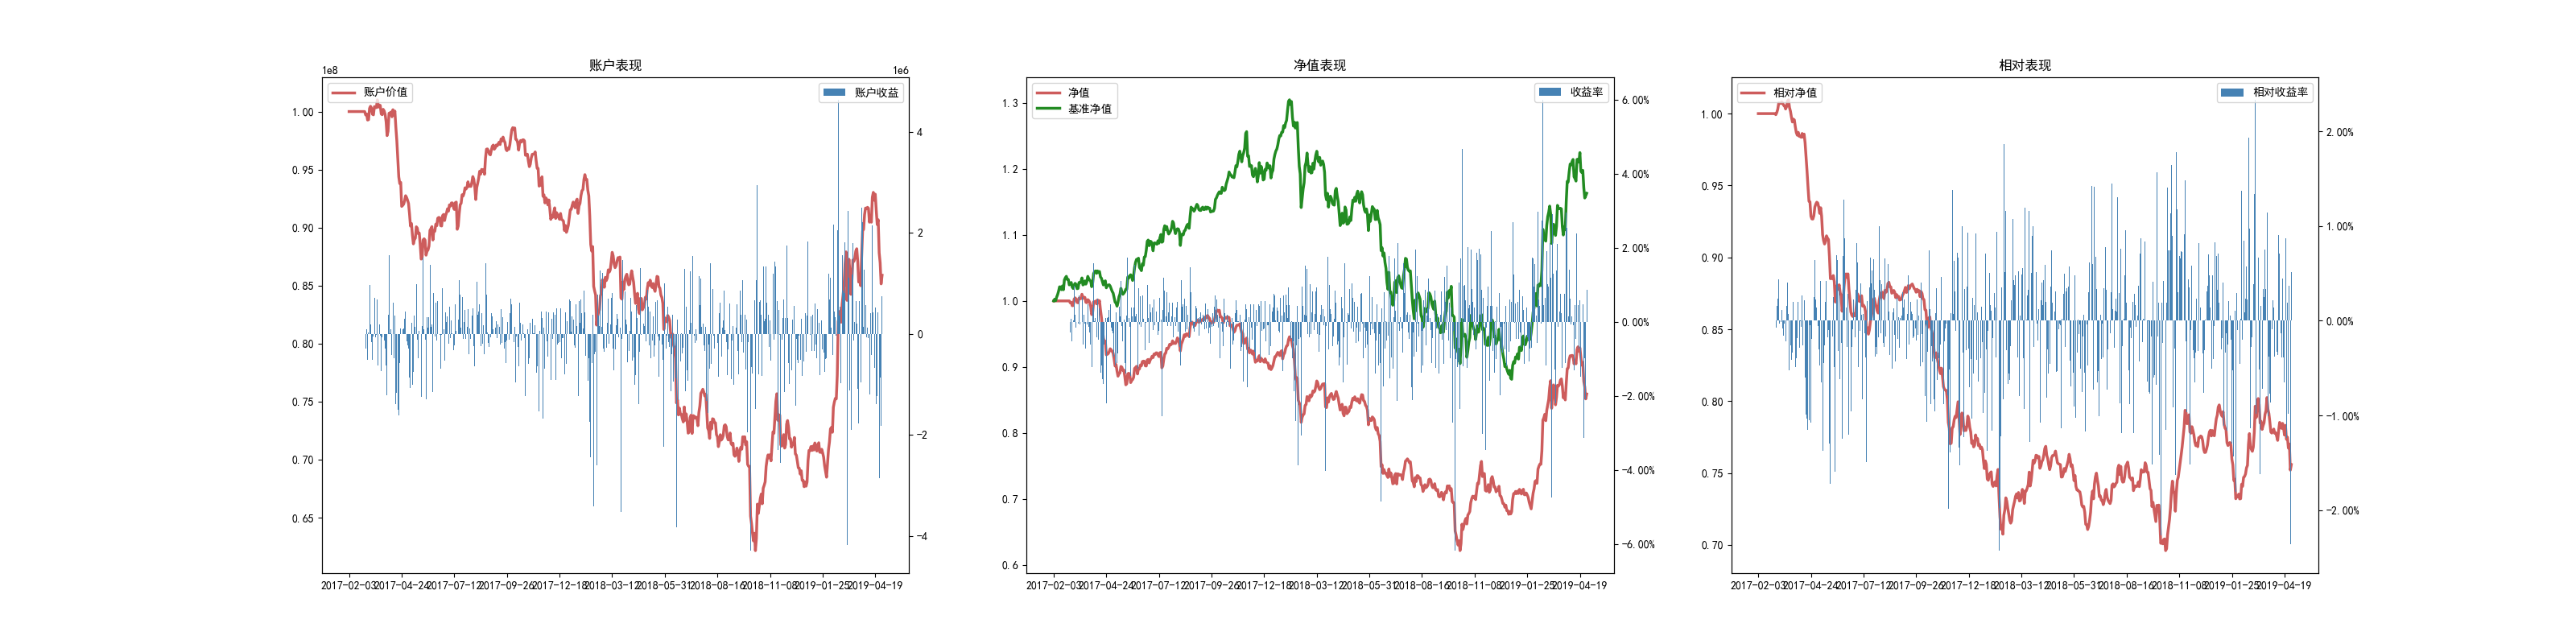

In [2]:
# 打分筛选选股策略
StartDT, EndDT = dt.datetime(2017, 1, 31), dt.datetime(2019, 4, 30)

# 获取基本信息
FT = HDB.getTable("stock_cn_day_bar_adj_backward_nafilled")
DTs = FT.getDateTime(ifactor_name="close", start_dt=StartDT, end_dt=EndDT)
IDs = FT.getID(ifactor_name="close")

# 再平衡时点序列
BalanceDTs = QS.Tools.DateTime.getMonthLastDateTime(DTs)# 月末

# 创建因子表
CFT = QS.FactorDB.CustomFT(name="MainFT")
CFT.addFactors(factor_table=HDB.getTable("stock_cn_day_bar_adj_backward_nafilled"), factor_names=["close"])
CFT.addFactors(factor_table=HDB.getTable("stock_cn_day_bar_nafilled"), factor_names=["if_trading"])
CFT.addFactors(factor_table=HDB.getTable("stock_cn_info"), factor_names=["if_listed"])
CFT.addFactors(factor_table=HDB.getTable("stock_cn_factor_barra_descriptor"), factor_names=["Industry"])
CFT.addFactors(factor_table=HDB.getTable("stock_cn_index_component"), factor_names=["hs_300_weight"])
CFT.addFactors(factor_list=[HDB.getTable("stock_cn_factor_barra").getFactor("Liquidity", new_name="alpha")])

CFT.setDateTime(DTs)
CFT.setID(IDs)

# 基准因子表
BenchmarkFT = HDB.getTable("index_cn_day_bar")

# 创建回测模型
Model = QS.BackTest.BackTestModel()

# 中证 500 增强策略
# 创建投资账户
iAccount = QS.BackTest.Strategy.DefaultAccount(market_ft=CFT)
iAccount.Args["初始资金"] = 1e8
iAccount.Args["负债上限"] = 0
iAccount.Args["交易延迟"] = False
iAccount.Args["目标ID"] = []# 空 list 表示因子表的所有 ID, 或者为 [ID]
iAccount.Args["买入限制"]["成交价"] = "close"
iAccount.Args["买入限制"]["禁止条件"] = "@if_trading!=1"# 满足该条件的 ID 不能买入
iAccount.Args["买入限制"]["交易费率"] = 0.003
iAccount.Args["买入限制"]["成交额"] = None
iAccount.Args["买入限制"]["成交额限比"] = 0.1# 当指定了买入限制的成交额, 则每个时点限制买入的总额为: 成交额*成交额限比
iAccount.Args["卖出限制"]["成交价"] = "close"
iAccount.Args["卖出限制"]["禁止条件"] = "@if_trading!=1"# 满足该条件的 ID 不能卖出
iAccount.Args["卖出限制"]["交易费率"] = 0.003
iAccount.Args["卖出限制"]["成交额"] = None
iAccount.Args["卖出限制"]["成交额限比"] = 0.1# 当指定了卖出限制的成交额, 则每个时点限制卖出的总额为: 成交额*成交额限比
iAccount.Args["卖出限制"]["允许卖空"] = False
iAccount.Args["最新价"] = "close"
# 创建策略模块
iModule = QS.BackTest.Strategy.HierarchicalFiltrationStrategy(name="我的策略", factor_table=CFT)
iModule.Args["信号滞后期"] = 0
iModule.Args["信号有效期"] = 1
iModule.Args["信号触发时点"] = BalanceDTs# 只有在指定的时点才触发选股信号
iModule.Args["筛选层数"] = 1
iModule.Args["第0层"]["信号类型"] = "多头信号"# 可选值: "多头信号", "空头信号"
iModule.Args["第0层"]["筛选条件"] = "@if_listed==1"# 如果指定了 ID 过滤条件, 则首先按照此条件过滤后再执行下面的选股算法
iModule.Args["第0层"]["目标因子"] = "alpha"
iModule.Args["第0层"]["排序方向"] = "升序"
iModule.Args["第0层"]["筛选方式"] = "定比"# 可选值: "定量", "定比", "定量&定比"
iModule.Args["第0层"]["筛选数目"] = 5# 定量方式选择的数目
iModule.Args["第0层"]["筛选上限"] = 0.10# 定比方式是选择分位数处于筛选下限和筛选上限之间的 ID
iModule.Args["第0层"]["筛选下限"] = 0.0# 筛选上限和筛选下限参数只有在筛选方式为 "定比" 或者 "定量&定比" 时才可用
iModule.Args["第0层"]["分类因子"] = ["Industry"]# 如果指定了分类因子, 则在每个子类别内依次运行筛选算法, 集合所有子类别内筛选出的 ID 总体作为本层筛选的最终 ID 序列
iModule.Args["第0层"]["换手缓冲"]["是否缓冲"] = False
iModule.Args["第0层"]["换手缓冲"]["筛选数目缓冲区"] = 15
iModule.Args["第0层"]["换手缓冲"]["筛选上限缓冲区"] = 0.25
iModule.Args["第0层"]["换手缓冲"]["筛选下限缓冲区"] = 0.25
iModule.Args["多头权重配置"]["权重因子"] = "等权"# 可选因子表中的因子
iModule.Args["多头权重配置"]["分类因子"] = ["Industry"]
iModule.Args["多头权重配置"]["类别权重"] = "hs_300_weight"# 可选因子表中的因子
iModule.Args["目标账户"] = iAccount
iModule.Args["交易目标"] = "锁定买卖金额"# 可选值: "锁定买卖金额", "锁定目标权重", "锁定目标金额"
iModule.Args["比较基准"]["因子表"] = BenchmarkFT
iModule.Args["比较基准"]["价格因子"] = "close"
iModule.Args["比较基准"]["基准ID"] = "000300.SH"
iModule.Args["比较基准"]["再平衡时点"] = BalanceDTs
Model.Modules.append(iModule)

# 运行模型
Model.run(dts=DTs)

# 展示结果
display(Model)

# 优化组合策略

QuantStudio 还实现了基于优化器的投资组合策略 Strateg.OptimizerStrategy, 该策略不需要用户实现接口方法, 只需要设置参数即可.

一个简单的组合优化策略示例如下, 策略的逻辑为最小方差组合:

==========历史回测==========
1. 初始化
耗时 : 0.52
2. 循环计算


100% (43 of 43) |########################| Elapsed Time: 0:00:04 Time:  0:00:04


耗时 : 11.15
3. 结果生成
耗时 : 0.11
总耗时 : 11.79


,绝对表现,基准表现,相对表现
起始时点,2018-07-31,2018-07-31,2018-07-31
结束时点,2018-09-28,2018-09-28,2018-09-28
时点数,43,43,43
总收益率,-2.52%,-2.24%,-0.82%
年化收益率,-14.60%,-13.08%,-4.95%
年化波动率,1.63%,22.26%,21.18%
Sharpe比率,-8.93,-0.59,-0.23
收益风险比,-8.93,-0.59,-0.23
胜率,32.56%,41.86%,55.81%
最大回撤率,2.71%,8.97%,7.50%

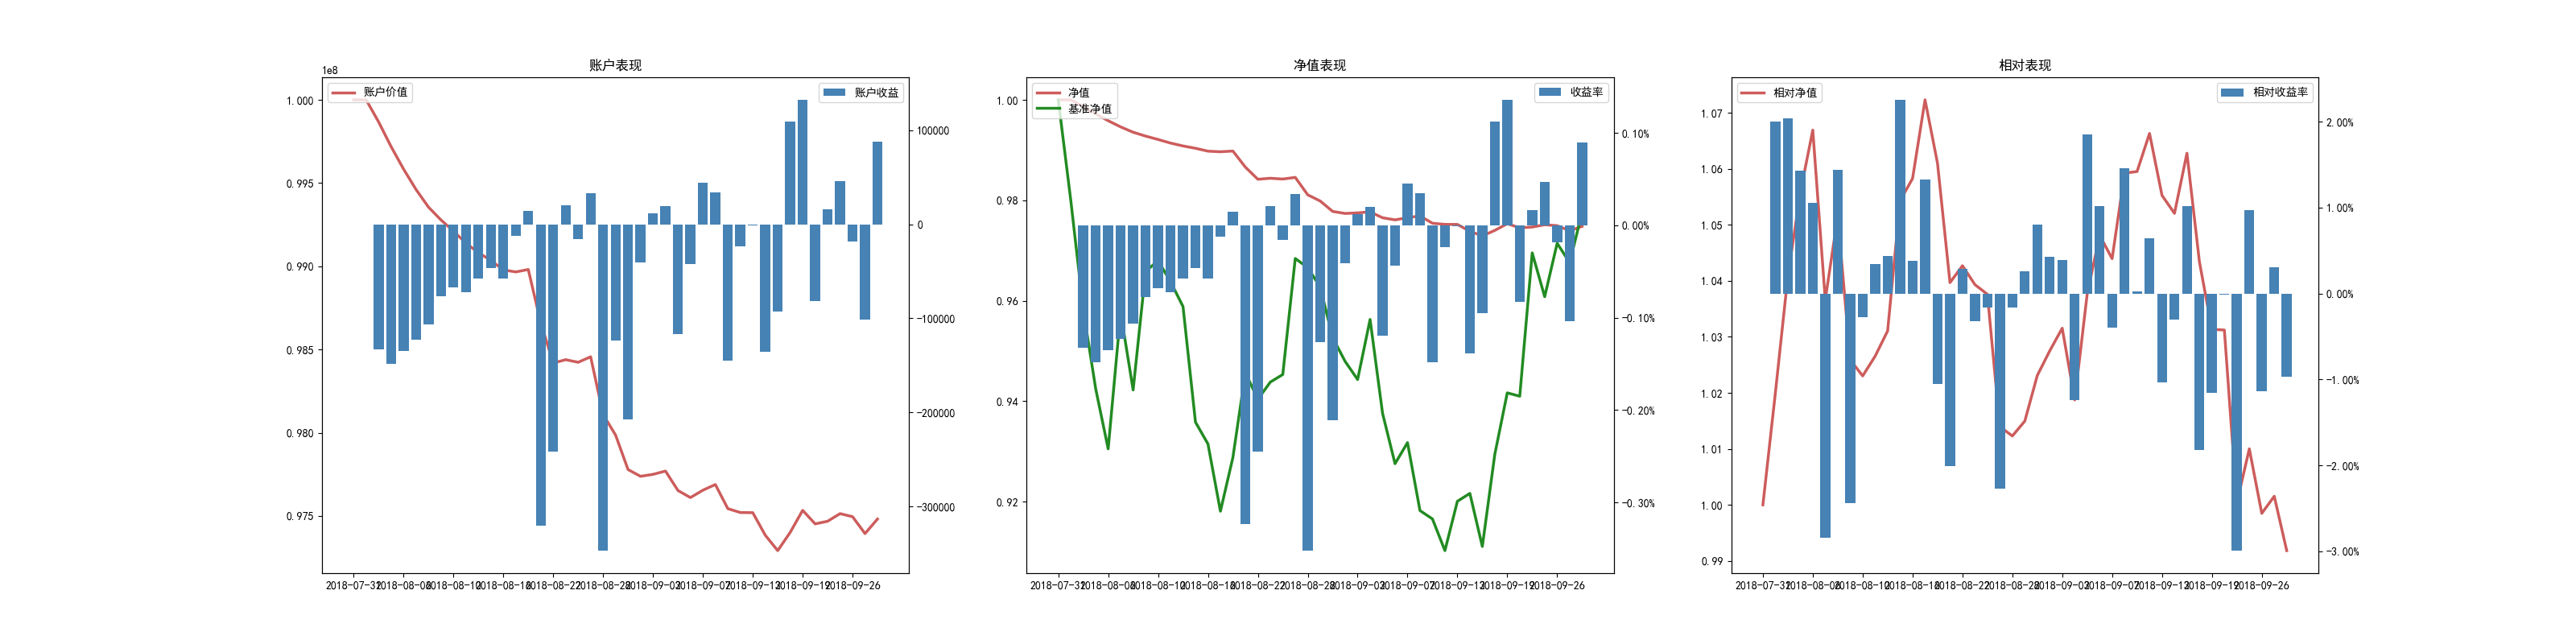

In [2]:
# 优化组合策略
StartDT, EndDT = dt.datetime(2018, 7, 31), dt.datetime(2018, 9, 28)

# 风险表
RT = RDB.getTable("BarraRiskData")
IDs = RT.getID()

# 创建自定义因子表
FT = HDB.getTable("stock_cn_day_bar_adj_backward_nafilled")
DTs = FT.getDateTime(ifactor_name="close", start_dt=StartDT, end_dt=EndDT)

# 再平衡时点序列
BalanceDTs = QS.Tools.DateTime.getMonthLastDateTime(DTs)# 月末

CFT = QS.FactorDB.CustomFT("MainFT")
CFT.addFactors(factor_table=HDB.getTable("stock_cn_day_bar_adj_backward_nafilled"), factor_names=["close"])
CFT.addFactors(factor_table=HDB.getTable("stock_cn_day_bar_nafilled"), factor_names=["if_trading", "amount"])
CFT.addFactors(factor_table=HDB.getTable("stock_cn_info"), factor_names=["if_listed"])
CFT.addFactors(factor_table=HDB.getTable("stock_cn_factor_barra_descriptor"), factor_names=["Industry"])
CFT.addFactors(factor_table=HDB.getTable("stock_cn_index_component"), factor_names=["hs_300_weight"])
CFT.addFactors(factor_list=[HDB.getTable("stock_cn_factor_barra").getFactor("Liquidity", new_name="alpha")])
CFT.setDateTime(DTs)
CFT.setID(IDs)

PC = QS.PortfolioConstructor.CVXPC()

# 设置优化目标
Objective = QS.PortfolioConstructor.MeanVarianceObjective(pc=PC)
Objective.Args["相对基准"] = False
Objective.Args["收益项系数"] = 0.0
Objective.Args["风险厌恶系数"] = 1.0
Objective.Args["换手惩罚系数"] = 0.0
Objective.Args["买入惩罚系数"] = 0.0
Objective.Args["卖出惩罚系数"] = 0.0
PC.Args["优化目标"] = Objective

# 设置约束条件
# 预算约束
iConstraint = QS.PortfolioConstructor.BudgetConstraint(pc=PC)
iConstraint.Args["限制上限"] = 1.0
iConstraint.Args["限制下限"] = 1.0
iConstraint.Args["相对基准"] = False
iConstraint.Args["舍弃优先级"] = -1# 当优化问题无解时, 按照舍弃优先级从大到小依次舍弃约束条件后求解优化问题直到有解为止, 优先级为-1的无法舍弃
PC.Args["约束条件"].append(iConstraint)

# 权重约束
iConstraint = QS.PortfolioConstructor.WeightConstraint(pc=PC)
iConstraint.Args["目标ID"] = ""# 空字符串表示所有 ID, 或者为 ID 过滤条件
iConstraint.Args["限制上限"] = 1.0
iConstraint.Args["限制下限"] = 0.0
iConstraint.Args["相对基准"] = False
iConstraint.Args["舍弃优先级"] = -1
PC.Args["约束条件"].append(iConstraint)

# 创建回测模型
Model = QS.BackTest.BackTestModel()

# 创建证券账户
iAccount = QS.BackTest.Strategy.DefaultAccount(market_ft=CFT)
iAccount.Args["初始资金"] = 100000000
iAccount.Args["负债上限"] = 0
iAccount.Args["交易延迟"] = False
iAccount.Args["目标ID"] = []# 空 list 表示因子表的所有 ID, 或者为 [ID]
iAccount.Args["买入限制"]["禁止条件"] = "@if_trading==1"# 满足该条件的 ID 不能买入
iAccount.Args["买入限制"]["交易费率"] = 0.0
iAccount.Args["买入限制"]["成交额限比"] = 0.1# 当指定了行情信息里的成交额, 则每个时点限制成交的总额为: 成交额*成交额限比
iAccount.Args["卖出限制"]["禁止条件"] = "@if_trading==1"# 满足该条件的 ID 不能卖出
iAccount.Args["卖出限制"]["交易费率"] = 0.0
iAccount.Args["卖出限制"]["成交额限比"] = 0.1
iAccount.Args["最新价"] = "close"

# 创建策略
iModule = QS.BackTest.Strategy.OptimizerStrategy(name="StockSelection", pc=PC, factor_table=CFT)
SignalDTs = QS.Tools.DateTime.getMonthLastDateTime(DTs)
iModule.Args["信号滞后期"] = 0
iModule.Args["信号有效期"] = 1
iModule.Args["信号触发时点"] = SignalDTs# 只有在指定的时点才触发选股信号
# iModule.Args["目标ID"] = "@hs_300_weight>0"# 只在满足条件的范围内选股
iModule.Args["预期收益"] = "alpha"

iModule.Args["风险表"] = RT
iModule.Args["基准权重"] = "hs_300_weight"
iModule.Args["成交金额"] = "amount"
iModule.Args["信号调整"]["调整方式"] = "忽略小权重"# 可选值: "忽略小权重", "累计权重"
iModule.Args["信号调整"]["小权重阈值"] = 1e-5# 该参数在调整方式为"忽略小权重"时有效
iModule.Args["信号调整"]["权重累计阈值"] = 0.97# 该参数在调整方式为"累计权重"时有效
iModule.Args["信号调整"]["是否归一"] = False# 信号经过调整后是否重新归一化
iModule.Args["信号调整"]["打印信息"] = False# 是否立即打印求解失败的信息
iModule.Args["目标账户"] = iAccount
iModule.Args["交易目标"] = "锁定买卖金额"# 可选值: "锁定买卖金额", "锁定目标权重", "锁定目标金额"
iModule.Args["比较基准"]["因子表"] = HDB.getTable("index_cn_day_bar")
iModule.Args["比较基准"]["价格因子"] = "close"
iModule.Args["比较基准"]["基准ID"] = "000300.SH"
iModule.Args["比较基准"]["再平衡时点"] = BalanceDTs
Model.Modules.append(iModule)

# 运行模型
Model.run(dts=DTs)

# 查看结果
display(Model)